<a href="https://colab.research.google.com/github/dhanushka365/SLEnergyConsumptionPrediction/blob/main/EP_testv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!pip install --prefix {sys.prefix} pandas tensorflow scikit-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preparing Time Series Data**
The data represents hourly total service requests for years 2013-2014, starting with monday

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the sequence data from csv
df = pd.read_csv('/content/drive/MyDrive/hourly_csv/AEP_hourly.csv')
requests = pd.DataFrame(data=df,columns=['AEP_MW'])
#if any missing value fill it by previous value and convert all requests into integer type
requests.ffill(inplace=True)
requests["AEP_MW"]=requests["AEP_MW"].astype(float).astype(int)
#Review loaded data
#print(requests.dtypes)
#requests.head()
print(requests)

        AEP_MW
0        13478
1        12865
2        12577
3        12517
4        12670
...        ...
121268   21089
121269   20999
121270   20820
121271   20415
121272   19993

[121273 rows x 1 columns]


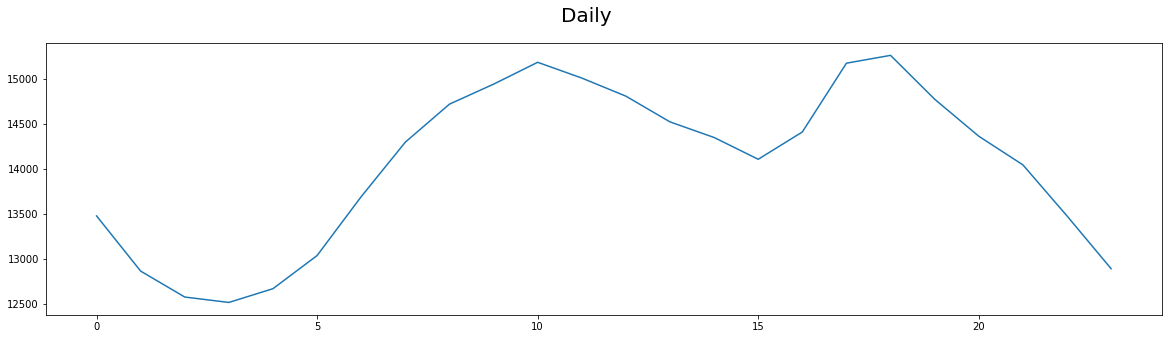

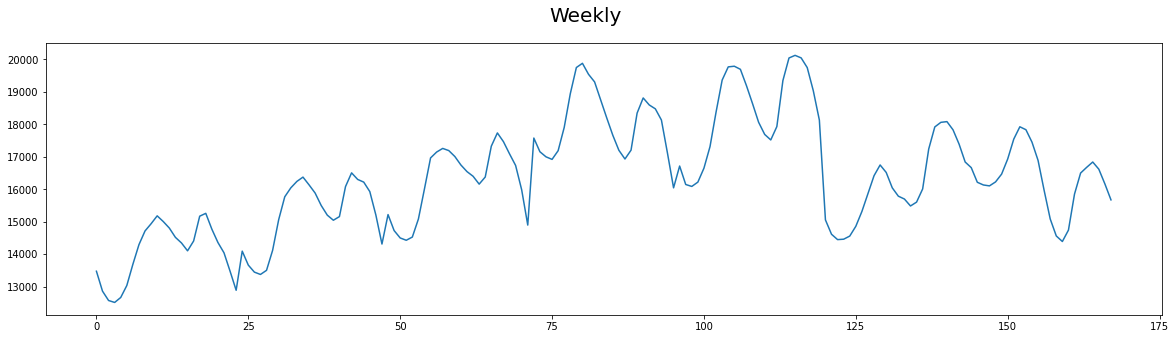

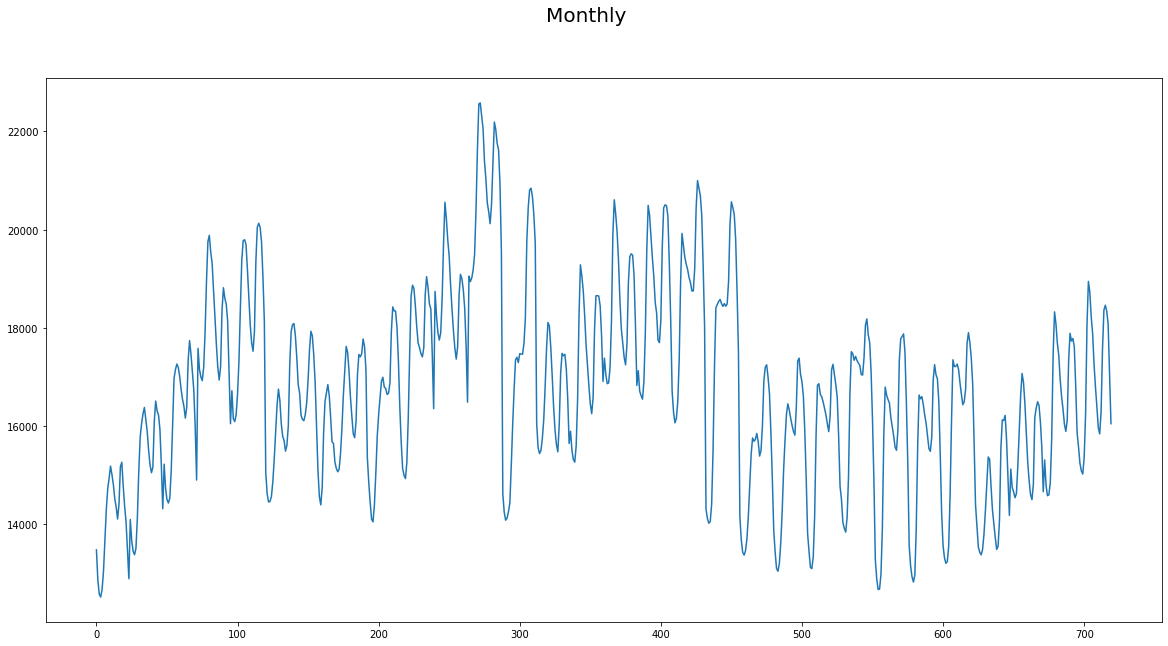

In [4]:
#plot the data loaded to visualize trends
#daily

plt.figure(figsize=(20,5)).suptitle("Daily",fontsize=20)
plt.plot(requests["AEP_MW"].head(24))
plt.show()

#weekly
plt.figure(figsize=(20,5)).suptitle("Weekly",fontsize=20)
plt.plot(requests["AEP_MW"].head(168))
plt.show()

#monthly
plt.figure(figsize=(20,10)).suptitle("Monthly",fontsize=20)
plt.plot(requests["AEP_MW"].head(720))
plt.show()


In [5]:
from sklearn.preprocessing import StandardScaler

#scale the data
print("Request Range before scaling:",min(requests.AEP_MW),max(requests.AEP_MW))
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
print("Request Range after scaling:",min(scaled_requests),max(scaled_requests))

#Traing data has to be sequential
train_size =8041

#Number of samples to lookback for each sample
lookback =720

#sperate training and test data
train_requests = scaled_requests[0:train_size,:]

#Add an additional week for lookback
test_requests = scaled_requests[train_size-lookback:,:]

print("\n Shaped of Train ,Test :", train_requests.shape ,test_requests.shape)



Request Range before scaling: 9581 25695
Request Range after scaling: [-2.28391613] [3.93437215]

 Shaped of Train ,Test : (8041, 1) (113952, 1)


# Build a LSTM model with Keras


In [6]:
#pepare RNN Dataset
def create_rnn_dataset(data, lookback=1):
  
  data_x,data_y = [],[]
  for i in range(len(data)- lookback -1):
    a = data[i:(i + lookback),0]
    data_x.append(a)
    data_y.append(data[i + lookback,0])
  return np.array(data_x),np.array(data_y)

#create x and y for training
train_req_x , train_req_y = create_rnn_dataset(train_requests , lookback)

#Reshape for use with LSTM
train_req_x = np.reshape(train_req_x,(train_req_x.shape[0],1,train_req_x.shape[1]))

print("shapes of x,y:",train_req_x.shape , train_req_y.shape)


shapes of x,y: (7320, 1, 720) (7320,)


In [10]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf


tf.random.set_seed(3)
ts_model =  Sequential()
#Add LSTM
ts_model.add(LSTM(256,input_shape=(1,lookback)))
ts_model.add(Dense(1))
ts_model.compile(loss="mean_squared_error",optimizer="adam",metrics=["mse"])
ts_model.summary()
ts_model.fit(train_req_x, train_req_y, epochs=5, batch_size=1,verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               1000448   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,000,705
Trainable params: 1,000,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
7320/7320 [==============================] - 56s 7ms/step - loss: 0.1753 - mse: 0.1753
Epoch 2/5
7320/7320 [==============================] - 59s 8ms/step - loss: 0.1088 - mse: 0.1088
Epoch 3/5
7320/7320 [==============================] - 57s 8ms/step - loss: 0.0889 - mse: 0.0889
Epoch 4/5
7320/7320 [==============================] - 62s 8ms/step - loss: 0.0809 - mse: 0.0809
Epoch 5/5
7320/7320 [==============================]

# Test the Model

In [11]:
#Preprocess
test_req_x , test_req_y =create_rnn_dataset(test_requests , lookback)
test_req_x = np.reshape(test_req_x,(test_req_x.shape[0],1,test_req_x.shape[1]))
ts_model.evaluate(test_req_x , test_req_y, verbose=1)

#predict for the training dataset
predict_on_train = ts_model.predict(train_req_x)
#Prdeict on the test dataset
predict_on_test = ts_model.predict(test_req_x)

predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)

3539/3539 [==============================] - 28s 8ms/step - loss: 0.1971 - mse: 0.1971


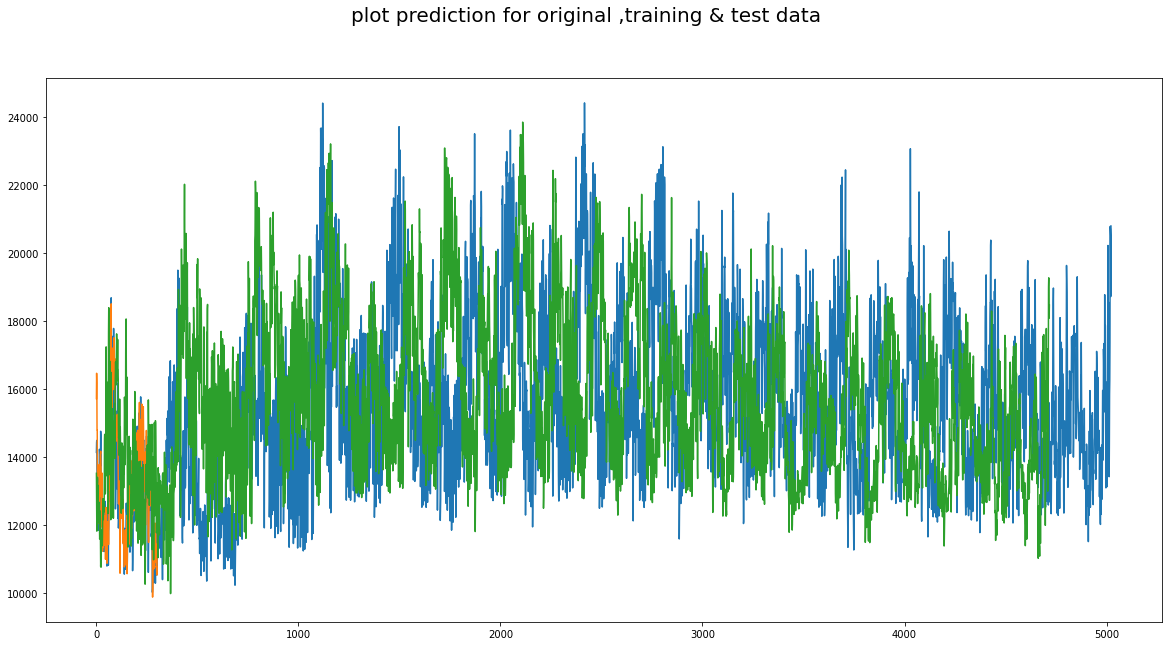

In [13]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train)+ len(predict_on_test)

#plot original data 
orig_data =requests.AEP_MW.to_numpy()
orig_data = orig_data.reshape(len(orig_data),1)

#cretae a plot for original data
orig_plot = np.empty((total_size , 1))
orig_plot[:,:] = np.nan
orig_plot[0:total_size,:]= orig_data[lookback:-2,]

#Create a plot for prediction on training
predict_train_plot =np.empty((total_size , 1))
predict_train_plot[:,:] = np.nan
predict_train_plot[0:len(predict_on_train),:] = predict_on_train

#Create a plot for prediction on testing
predict_test_plot =np.empty((total_size , 1))
predict_test_plot[:,:] = np.nan
predict_test_plot[0:len(predict_on_test),:] = predict_on_test

#plot the graphs
plt.figure(figsize=(20,10)).suptitle("plot prediction for original ,training & test data", fontsize=20)
plt.plot(orig_plot[::24])
plt.plot(predict_train_plot[::24])
plt.plot(predict_test_plot[::24])
plt.show()








# Forecasting future Service loads

In [14]:
curr_input = test_req_x[-1,:].flatten()

#Predict for the hours
predict_for =24*30

for i in range(predict_for):
  this_input = curr_input[-lookback:]
  this_input = this_input.reshape((1,1,lookback))
  this_prediction = ts_model.predict(this_input)

  curr_input = np.append(curr_input, this_prediction.flatten())
predict_on_future = np.reshape(np.array(curr_input[predict_for:]),(predict_for,1))
predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])

[[19062.41417717]
 [18846.97228508]
 [18675.81866902]
 [18393.53134008]
 [18295.49480533]]


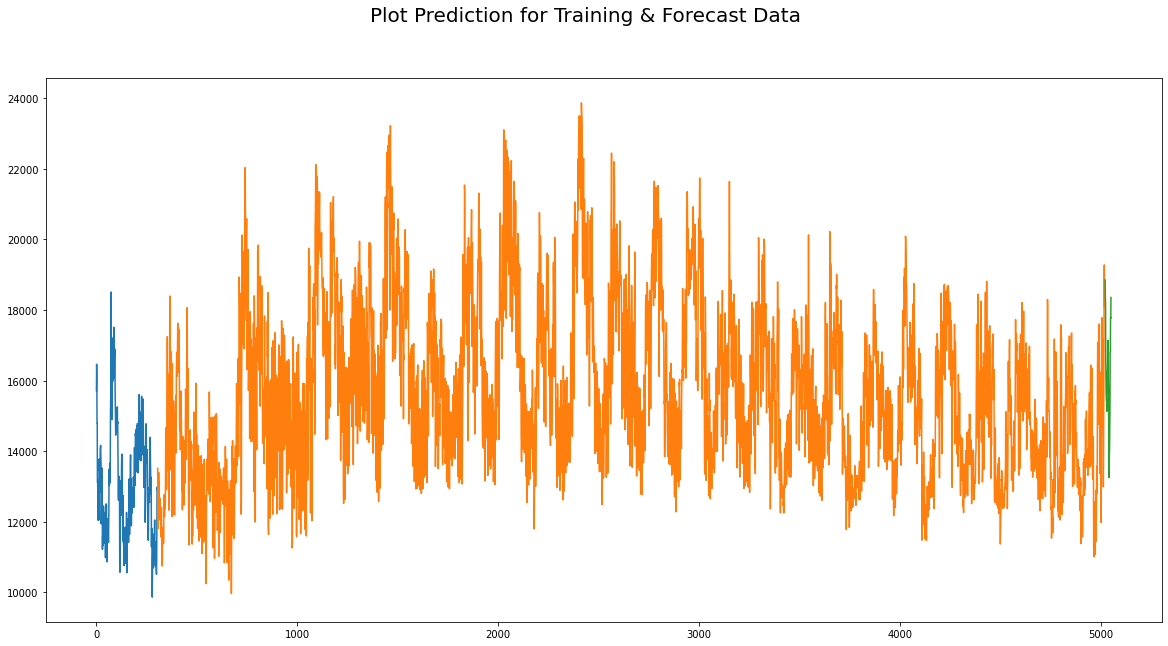

In [16]:
#plot the traunung data with the forcasting data
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)
                                                                
#setup training chart
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:,:] = np.nan
predict_train_plot[0:len(predict_on_train),:] = predict_on_train 

#setup test chart
predict_test_plot = np.empty((total_size , 1))
predict_test_plot[:,:] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test),:]=predict_on_test

#setup future forecast chart
predict_future_plot = np.empty((total_size,1))
predict_future_plot[:,:]=np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size,:]=predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Prediction for Training & Forecast Data",fontsize=20)
plt.plot(predict_train_plot[::24])
plt.plot(predict_test_plot[::24])
plt.plot(predict_future_plot[::24])
plt.show()


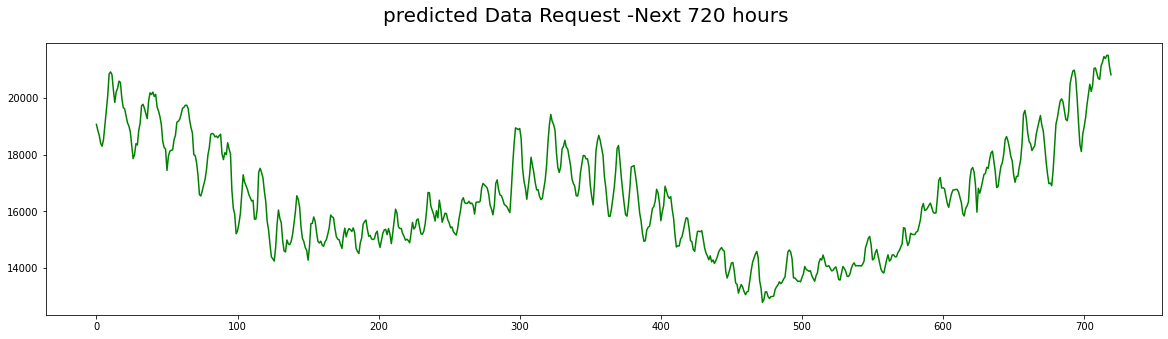

In [17]:
plt.figure(figsize=(20,5)).suptitle("predicted Data Request -Next 720 hours",fontsize=20)
plt.plot(predict_on_future , color='g')
plt.show()